# Access SoilDB to return variables needed for AGB modeling
current version of gSSURGO & gNATSGO soil data for CONUS

PDF of all vars:  
https://sdmdataaccess.sc.egov.usda.gov/documents/TablesAndColumnsReport.pdf

Demo notebook:  
https://ncss-tech.github.io/AQP/soilDB/WCS-demonstration-01.html#ISSR-800

A collection of functions for reading data from USDA-NCSS soil databases  
https://ncss-tech.github.io/soilDB/  

Vector soils interactive map  
https://casoilresource.lawr.ucdavis.edu/gmap/?loc=37.09873,-119.73621,z13 

*Beaudette, D., Skovlin, J., Roecker, S., Brown, A. (2022). soilDB:
Soil Database Interface. R package version 2.7.6.
<https://CRAN.R-project.org/package=soilDB>*

In [ ]:
install.packages('soilDB')
#remotes::install_github("ncss-tech/soilDB", dependencies = FALSE, upgrade = FALSE, build = FALSE)

# terra
install.packages('terra', repos='https://rspatial.r-universe.dev')

In [ ]:
install.packages('rasterVis')

In [1]:
# latest from GitHub
library(soilDB)

# wrangling polygons and CRS transformations
library(sf)

# raster data / analysis
# need latest: install.packages('terra', repos='https://rspatial.r-universe.dev')
library(terra)

# raster visualization
library(rasterVis)
library(viridisLite)

# soil classification
library(aqp)

# color palettes and manipulation
library(RColorBrewer)
library(colorspace)

Linking to GEOS 3.10.1, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE

terra version 1.4.22

Loading required package: lattice

This is aqp 1.42


Attaching package: ‘colorspace’


The following object is masked from ‘package:terra’:

    RGB




## Make a bbox for MLBS site

In [2]:
# make a bounding box and assign a CRS (4326: GCS, WGS84)
bbox_MLBS <- st_bbox(
  c(xmin = -80.7, xmax = -80.4, ymin = 37.2, ymax = 37.5), 
  crs = st_crs(4326)
)

# convert to sf polygon for later use in figures
bbox_MLBS <- st_as_sfc(bbox_MLBS)

In [3]:
# gSSURGO grid: 30m resolution
(mu_gSSURGO <- mukey.wcs(bbox_MLBS, db = 'gSSURGO', res = 30))

class       : SpatRaster 
dimensions  : 1248, 1047, 1  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 1334055, 1365465, 1681223, 1718663  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83 / Conus Albers (EPSG:5070) 
source      : memory 
categories  : mukey, ID 
name        :   mukey 
min value   :  514430 
max value   : 2525459 

In [4]:
# gNATSGO grid: 300m resolution
(mu_gNATSGO <- mukey.wcs(bbox_MLBS, db = 'gNATSGO', res = 30))

class       : SpatRaster 
dimensions  : 1248, 1047, 1  (nrow, ncol, nlyr)
resolution  : 30, 30  (x, y)
extent      : 1334055, 1365465, 1681223, 1718663  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83 / Conus Albers (EPSG:5070) 
source      : memory 
categories  : mukey, ID 
name        :   mukey 
min value   :  514430 
max value   : 2525459 

In [5]:
# RSS grid: 10m resolution
#(mu_RSS <- mukey.wcs(bbox_MLBS, db = 'RSS', res = 10))

In [6]:
attr(mu_gSSURGO, 'layer name')

[1] "gSSURGO map unit keys"

In [9]:
f = st_read('/home/pmontesa/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg')

Multiple layers are present in data source /panfs/ccds02/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg, reading layer `all'.
Use `st_layers' to list all layer names and their type in a data source.
Set the `layer' argument in `st_read' to read a particular layer.


Warning message in evalq((function (..., call. = TRUE, immediate. = FALSE, noBreaks. = FALSE, :
“automatically selected the first layer in a data source containing more than one.”


Reading layer `all' from data source 
  `/panfs/ccds02/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_DSM.gpkg' 
  using driver `GPKG'
Simple feature collection with 27322 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -155.4601 ymin: 19.48193 xmax: -71.18201 ymax: 65.25579
Geodetic CRS:  WGS 84


Warning message in plot.sf(f, add = TRUE):
“ignoring all but the first attribute”
Warning message in plot.sf(f, add = TRUE):
“ignoring all but the first attribute”


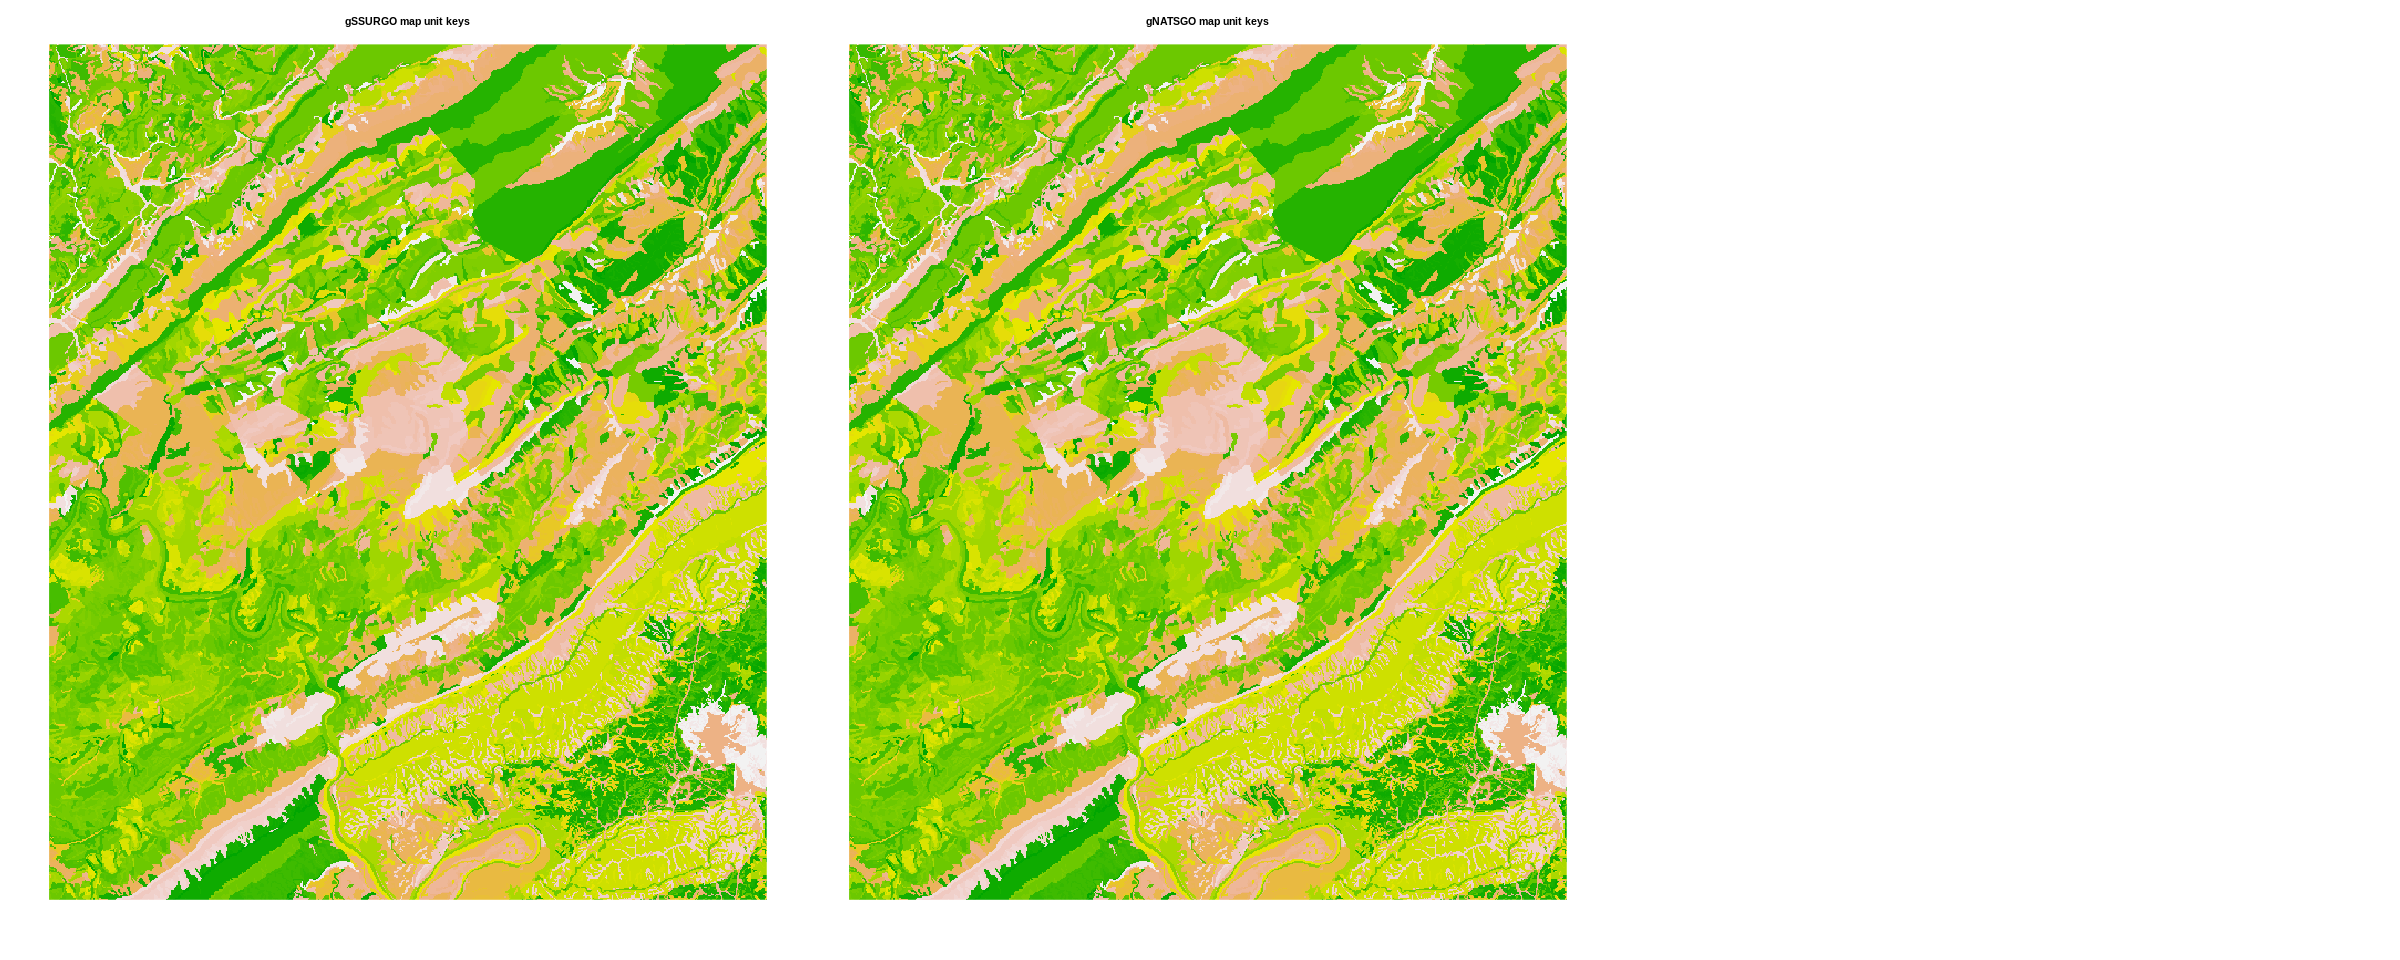

In [10]:
options(repr.plot.width = 20, repr.plot.height = 8)

# graphical comparison
par(mfcol = c(1, 3))

# gSSURGO
plot(mu_gSSURGO, axes = FALSE, legend = FALSE, main = attr(mu_gSSURGO, 'layer name'))
# original BBOX
plot(f, add = TRUE)

# gNATSGO
plot(mu_gNATSGO, axes = FALSE, legend = FALSE, main = attr(mu_gNATSGO, 'layer name'))
# original BBOX
plot(f, add = TRUE)

## RSS
#plot(z, axes = FALSE, legend = FALSE, main = attr(z, 'layer name'), ext = x)
# original BBOX
#plot(f, add = TRUE)

In [12]:
# # Some vars, but not all?
# vars_df = WCS_details(wcs = 'ISSR800')
# head(vars_df) #%>% dplyr::filter(var %in% 'bulk')

## Choose SSURGO variables of interest
#### https://sdmdataaccess.sc.egov.usda.gov/documents/TablesAndColumnsReport.pdf
1. Clay content 0-25cm  (claytotal)  (%)
2. Cation exchange capacity at pH 7 0-25cm  (cec7)  (cmol(+)/kg)  
3. Soil Organic Matter - Max (percent by weight)  (om)  
4. Plant available water storage 0-50cm  (aws050wta)  
<s>5. Depth to Restrictive Layer (cm) (resdept)</s>
6. Depth to bedrock (min)


In [19]:
MEAS_TYPE = "r" # representative
TOP = 0
#
# Set these lists to correspond to the soil layers to be extracted
#
BOTTOM_LIST = c(25, 25, 50, 25
                #,50 
                #,50
               )
METHOD_LIST = c("Dominant Component (Numeric)", "Dominant Component (Numeric)", "MAX" 
                ,"MIN"
                #,'Weighted Average'
                #,"Dominant Component (Numeric)"
               )

# Original test vars
#VARS_PHYSICAL_NAMES = c("wfifteenbar","dbthirdbar", "awc", "ph1to1h2o")
#VARS_DESC  = c('15 bar H2O','1/3 Bar Bulk Density', '', '')
#VARS_UNITS = c('%','g/cm^3', '', '')

# Current variables for modelling AGB
VARS_PHYSICAL_NAMES = c("claytotal", "cec7", "om"
                        ,'brockdepmin'
                        #,"aws050wta"
                        #,"resdept"
                       )
VARS_DESC  = c('Clay content', 'Cation exchange capacity at pH 7', 'Soil Organic Matter - Max (percent by weight)'
               ,'Depth to bedrock (min)'
               #,'Plant available water storage',
               #,'Depth to Restrictive Layer (cm)'
              )
VARS_UNITS = c('%','cmol(+)/kg', '%'
               , 'cm'
               ,''
               ,''
              )
#VARS_UOM = c()

VARS_LIST = paste(VARS_PHYSICAL_NAMES, MEAS_TYPE, sep='_')


In [ ]:
#?get_SDA_property

In [20]:
# extract RAT for thematic mapping
rat <- cats(mu_gSSURGO)[[1]]
RASTER_LAYER_NAMES = c()
for(i in seq_along(VARS_LIST)){
    
    VAR = VARS_LIST[i]
    LYR_NAME = paste(VAR, TOP, BOTTOM_LIST[i], sep='_')
    RASTER_LAYER_NAMES = c(RASTER_LAYER_NAMES, LYR_NAME)
    print(LYR_NAME)
    p <-  get_SDA_property(property = VARS_LIST[i],
                           method = METHOD_LIST[i], 
                           mukeys = as.integer(rat$mukey),
                           top_depth = TOP,
                           bottom_depth = BOTTOM_LIST[i])

    # convert areasymbol into a factor easy plotting later
    p$areasymbol <- factor(p$areasymbol)

    # merge aggregate soil data into RAT
    rat <- merge(rat, p %>% dplyr::select(`VAR`, 'mukey'), by.x = 'mukey', by.y = 'mukey', sort = FALSE, all.x = TRUE)
    levels(mu_gNATSGO) <- rat

    }

# result is a grid of map unit keys + RAT

# reset the active category to 1
# this will ensure that all variables in the RAT will be converted by catalyze(mu)
activeCat(mu_gNATSGO) <- 1

# convert mukey grid + RAT -> stack of numerical grids
mu.stack <- catalyze(mu_gNATSGO)

# keep only properties / remove IDs
mu.stack <- mu.stack[[VARS_LIST]]

[1] "claytotal_r_0_25"
[1] "cec7_r_0_25"
[1] "om_r_0_50"
[1] "brockdepmin_r_0_25"


ERROR: Error in doTryCatch(return(expr), name, parentenv, handler): Bad Request (HTTP 400).


In [18]:
options(repr.plot.width = 20, repr.plot.height = 8)

var_idx = 0
for(i in seq_along(VARS_LIST)){
    var_idx = var_idx + 1
    VAR = VARS_LIST[i]
    BOTTOM = BOTTOM_LIST[i]
    METHOD = METHOD_LIST[i]
    # note implicit simplification via maxpixels
    print(
        levelplot(
          mu.stack[[VAR]], 
          main = paste0(VARS_DESC[i],' (',VARS_UNITS[i],')\n',TOP,'-',BOTTOM,'cm\n',METHOD),
          margin = FALSE, 
          scales = list(draw = FALSE), 
          col.regions = viridis,
          maxpixels = 1e5
        )
    )
}

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'levelplot': object 'mu.stack' not found


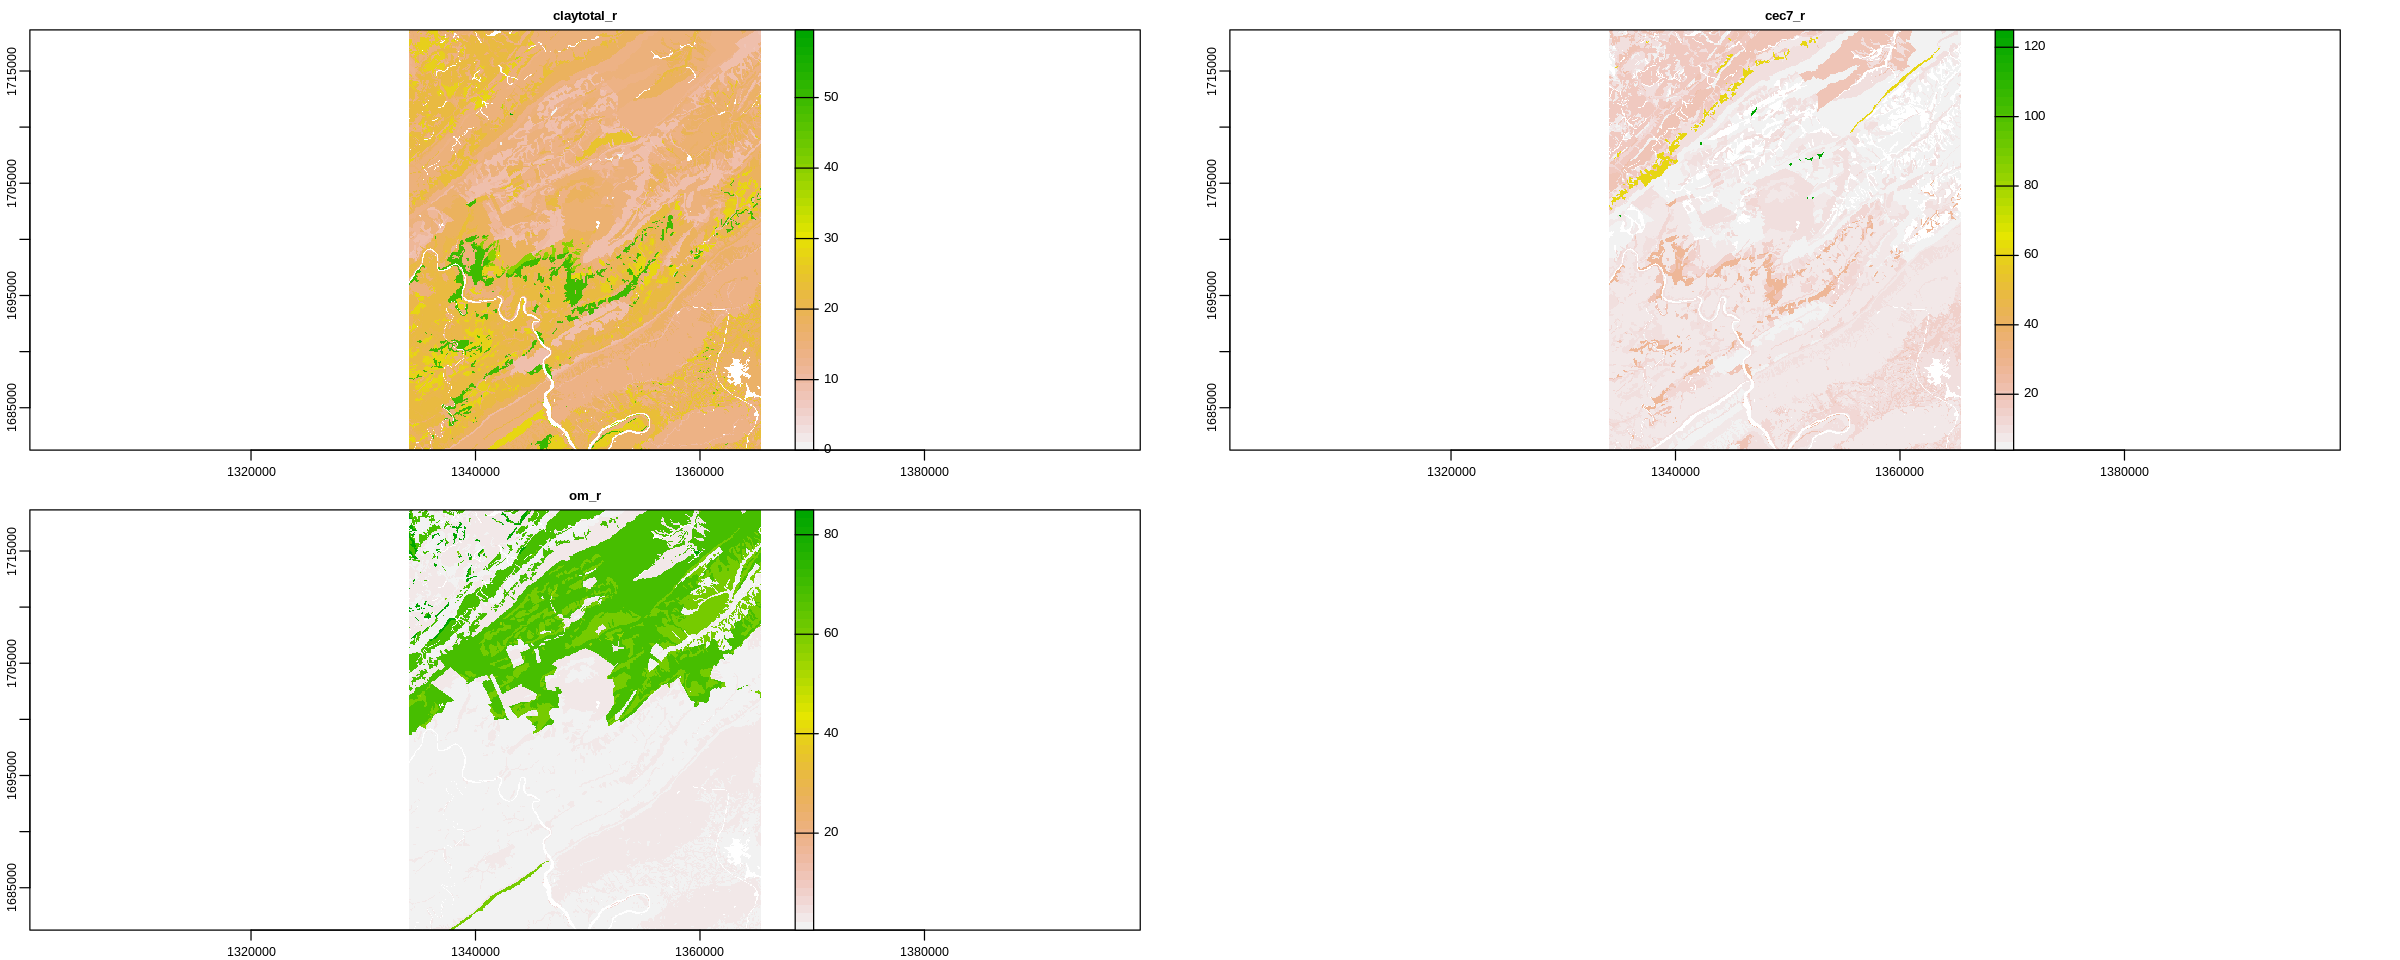

In [146]:
plot(mu.stack)

In [163]:
names(mu.stack) = RASTER_LAYER_NAMES

for(NAME in RASTER_LAYER_NAMES){    
    print(NAME)
    terra::writeRaster(mu.stack[[NAME]], paste0("/explore/nobackup/projects/ilab/data/AGB/SSURGO/soilDB/soilsDB_MLBS_",NAME,".tif"), overwrite=TRUE)
    }

[1] "claytotal_r_0_25"
[1] "cec7_r_0_25"
[1] "om_r_0_50"
